# 1. Import the needed libraries

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import ceil
from sklearn.impute import KNNImputer

# 2. Import data

In [75]:
df = pd.read_csv('/content/train_data.csv', low_memory=False)

# 3. Explore the data

In [76]:
df.head(5)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

  COVID-19 Indicator,  Agreement Reached and Attorney/Representative should be a bool and not an object.

In [78]:
df['Attorney/Representative'].value_counts()
df['Attorney/Representative'] = df['Attorney/Representative'].replace({'Y': True, 'N': False})
df['Attorney/Representative'] = df['Attorney/Representative'].astype(bool)

In [79]:
df['COVID-19 Indicator'].value_counts()
df['COVID-19 Indicator'] = df['COVID-19 Indicator'].replace({'Y': True, 'N': False})
df['COVID-19 Indicator'] = df['COVID-19 Indicator'].astype(bool)

In [80]:
df['Agreement Reached'].value_counts()
df['Agreement Reached'] = df['Agreement Reached'].replace({'1': True, '0': False})
df['Agreement Reached'] = df['Agreement Reached'].astype(bool)

Accident Date is not an object. Should be in format DateTime.

In [81]:
# Convert the 'Accident Date' column to datetime format
df['Accident Date'] = pd.to_datetime(df['Accident Date'], errors='coerce')
df['Assembly Date'] = pd.to_datetime(df['Assembly Date'], errors='coerce')
df['C-2 Date'] = pd.to_datetime(df['C-2 Date'], errors='coerce')
df['C-3 Date'] = pd.to_datetime(df['C-3 Date'], errors='coerce')
df['First Hearing Date'] = pd.to_datetime(df['First Hearing Date'], errors='coerce')


Alternative Dispute Resolutio,Carrier Type,Gender and WCB Decision should be a category and not an *object*

In [82]:
df['Alternative Dispute Resolution'] = df['Alternative Dispute Resolution'].astype('category')
df['Carrier Type'] = df['Carrier Type'].astype('category')
df['Gender'] = df['Gender'].astype('category')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64       
 2   Alternative Dispute Resolution      574026 non-null  category      
 3   Assembly Date                       593471 non-null  datetime64[ns]
 4   Attorney/Representative             593471 non-null  bool          
 5   Average Weekly Wage                 545375 non-null  float64       
 6   Birth Year                          544948 non-null  float64       
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 9   Carrier Name                        574026 non-null  object        
 10  Carrier 

key statistics of numerical and categorical columns

In [84]:
df.describe()

,Accident Date,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Claim Identifier,First Hearing Date,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents
count,570337,574026.000000,593471,5.453750e+05,544948.000000,559466,187245,5.934710e+05,150798,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000
mean,2021-04-28 21:00:27.892982784,42.114270,2021-07-19 03:25:38.260841728,4.910883e+02,1886.767604,2021-07-16 20:11:19.865443328,2021-07-26 21:31:28.449891840,2.366760e+07,2022-03-19 05:07:38.218278400,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,3.006559
min,1961-09-06 00:00:00,0.000000,2020-01-01 00:00:00,0.000000e+00,0.000000,1996-01-12 00:00:00,1992-11-13 00:00:00,5.393066e+06,2020-01-30 00:00:00,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000
25%,2020-09-14 00:00:00,31.000000,2020-10-26 00:00:00,0.000000e+00,1965.000000,2020-11-06 00:00:00,2020-10-27 00:00:00,5.593414e+06,2021-06-01 00:00:00,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,1.000000
50%,2021-06-27 00:00:00,42.000000,2021-07-29 00:00:00,0.000000e+00,1977.000000,2021-08-09 00:00:00,2021-07-21 00:00:00,5.791212e+06,2022-03-09 00:00:00,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,3.000000
75%,2022-03-21 00:00:00,54.000000,2022-04-19 00:00:00,8.410000e+02,1989.000000,2022-04-26 00:00:00,2022-04-20 00:00:00,5.991000e+06,2023-01-11 00:00:00,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,5.000000
max,2023-09-29 00:00:00,117.000000,2022-12-31 00:00:00,2.828079e+06,2018.000000,2024-06-01 00:00:00,2024-05-31 00:00:00,9.998917e+08,2024-06-07 00:00:00,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,6.000000
std,NaN,14.256432,NaN,6.092918e+03,414.644423,NaN,NaN,1.079271e+08,NaN,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,2.000801


Additional Notes:

- The minimum age recorded is 0, which doesn't make sense as it indicates an impossible age for a worker. These values might represent missing (NaN) data or data entry errors.
- The maximum age recorded is 117, which is highly unusual and likely an outlier. It should be investigated to determine if these values are real or errors.
- The minimum weekly wage recorded is 0, which may indicate missing values, errors, or individuals with no wage information. These values need to be filtered or imputed depending on the context.
- The maximum weekly wage recorded is 2,828,079, which seems to be an extreme outlier. Such high values could be data entry errors and should be investigated further.
- The minimum birth year is 0, which is clearly a data entry error, as no worker could be born in year 0.
- The maximum birth year is 2018, indicating that very recently born individuals are being recorded as workers, which is impossible. These values are likely errors and should be corrected.
- The maximum values in several columns, such as Age at Injury, Average Weekly Wage, and Birth Year, are highly unusual and likely represent outliers or data errors. A data cleaning strategy should be implemented to either remove or correct these values.

In [85]:
df.describe(include=['object'])

,Carrier Name,Claim Injury Type,County of Injury,District Name,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,574026,574026,574026,574026,564068,574026,558386,558369,556944,545389,574026
unique,2046,8,63,8,20,5,74,56,54,8286,1
top,STATE INSURANCE FUND,2. NON-COMP,SUFFOLK,NYC,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,111144,291078,60430,270779,114339,265981,46610,153373,51862,3398,574026


## Checking for duplicated lines

In [86]:
# Check for duplicates and return a boolean value
has_duplicates = df.duplicated().any()
print(f"Existence of duplicates: {has_duplicates}")

Existence of duplicates: False


## Checking vor NA data

In [87]:
(df.isna().mean()*100).sort_values(ascending=False)

,0
OIICS Nature of Injury Description,100.000000
IME-4 Count,77.622664
First Hearing Date,74.590502
C-3 Date,68.449174
Birth Year,8.176137
Average Weekly Wage,8.104187
Zip Code,8.101828
WCIO Part Of Body Description,6.154808
WCIO Part Of Body Code,6.154808
WCIO Nature of Injury Description,5.914695


## Explore the accident date variable

In [100]:
median_accident_date = df['Accident Date'].median()
df['Accident Date'].fillna(median_accident_date, inplace=True)
df['Accident Date'].isna().sum()

<ipython-input-100-6591f9ba1dbe>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Accident Date'].fillna(median_accident_date, inplace=True)


0

In [99]:
accident_date_count_series = df['Accident Date'].value_counts().sort_index()

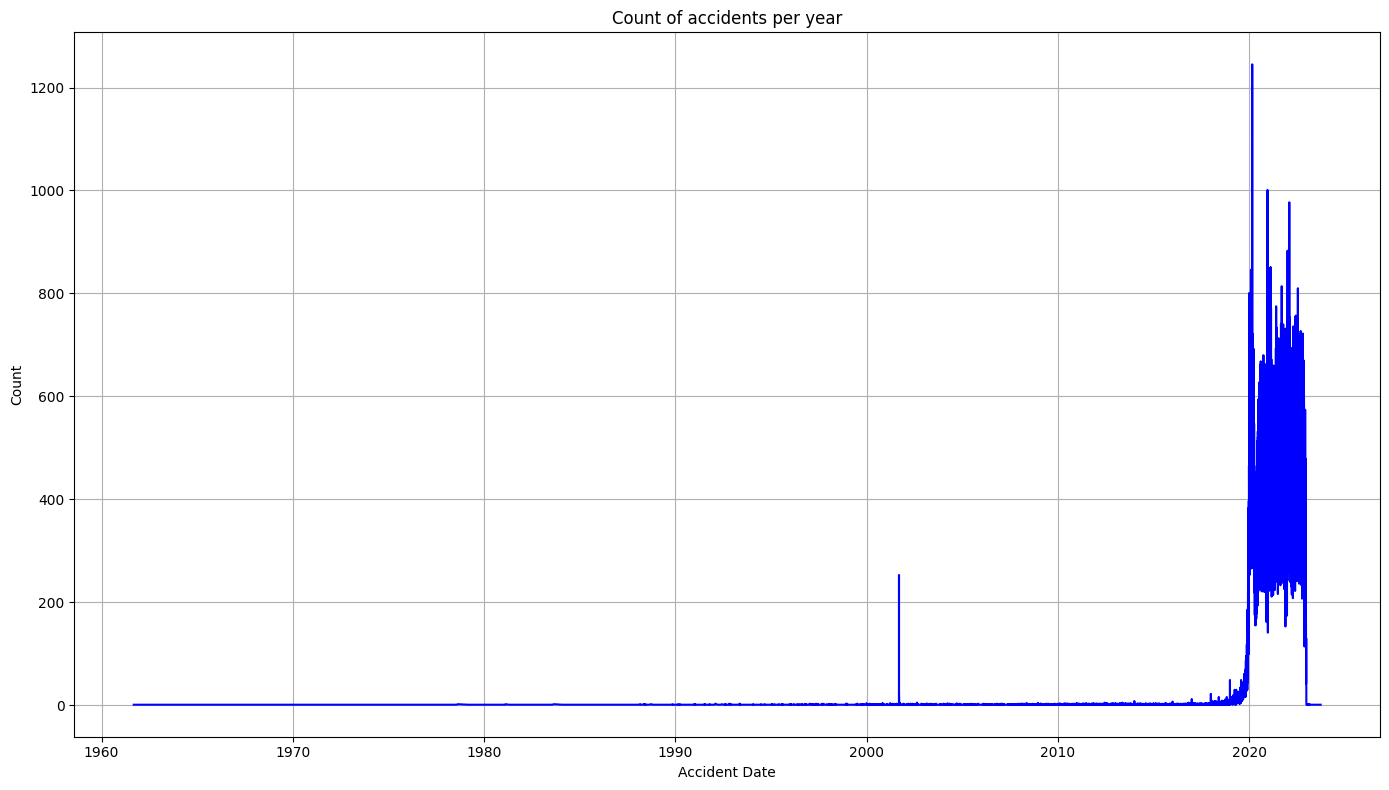

In [89]:
plt.figure(figsize=(14, 8))
plt.plot(accident_date_count_series.index, accident_date_count_series.values, linestyle='-', color='b')
plt.title('Count of accidents per year')
plt.xlabel('Accident Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

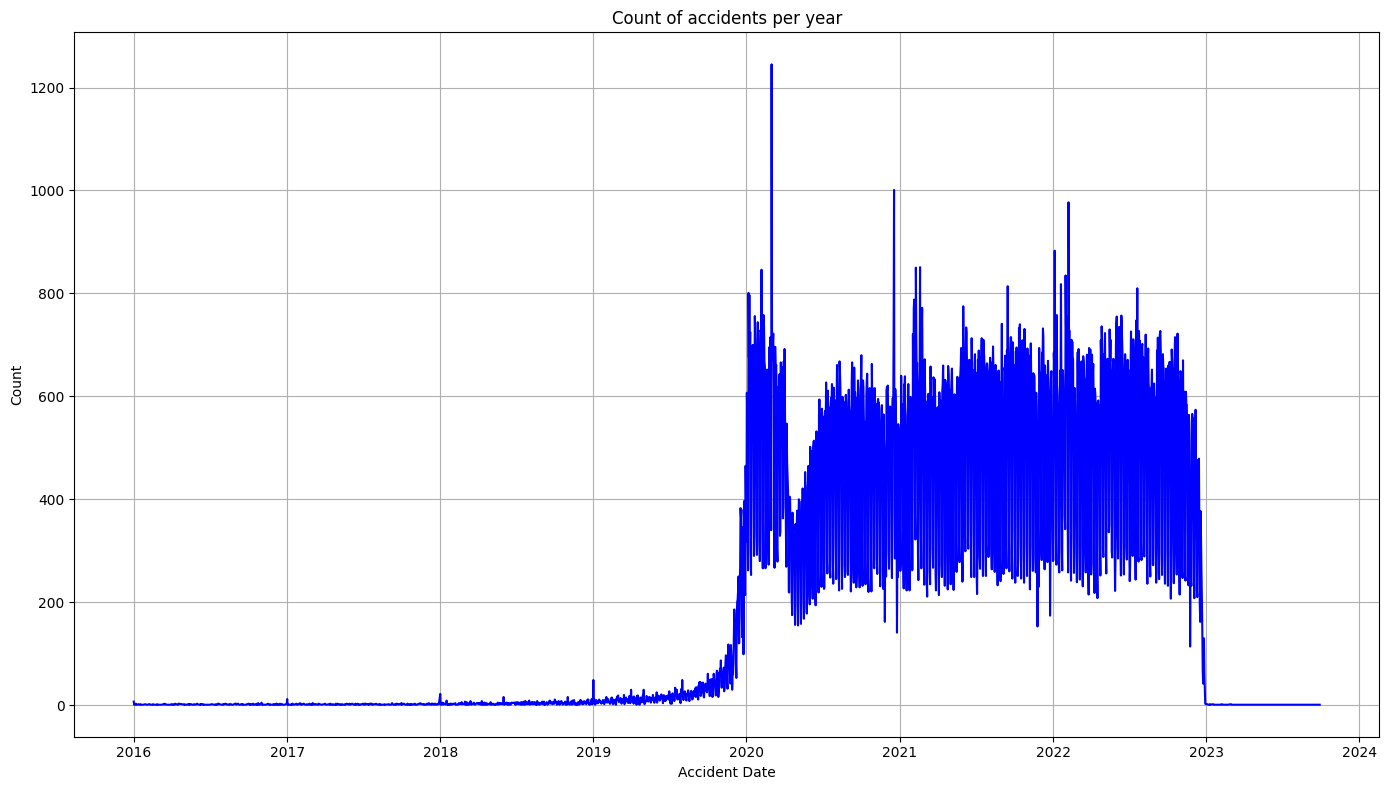

In [90]:
accident_date_count_series1 = accident_date_count_series[accident_date_count_series.index > '2015-12-31']
plt.figure(figsize=(14, 8))
plt.plot(accident_date_count_series1.index, accident_date_count_series1.values, linestyle='-', color='b')
plt.title('Count of accidents per year')
plt.xlabel('Accident Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

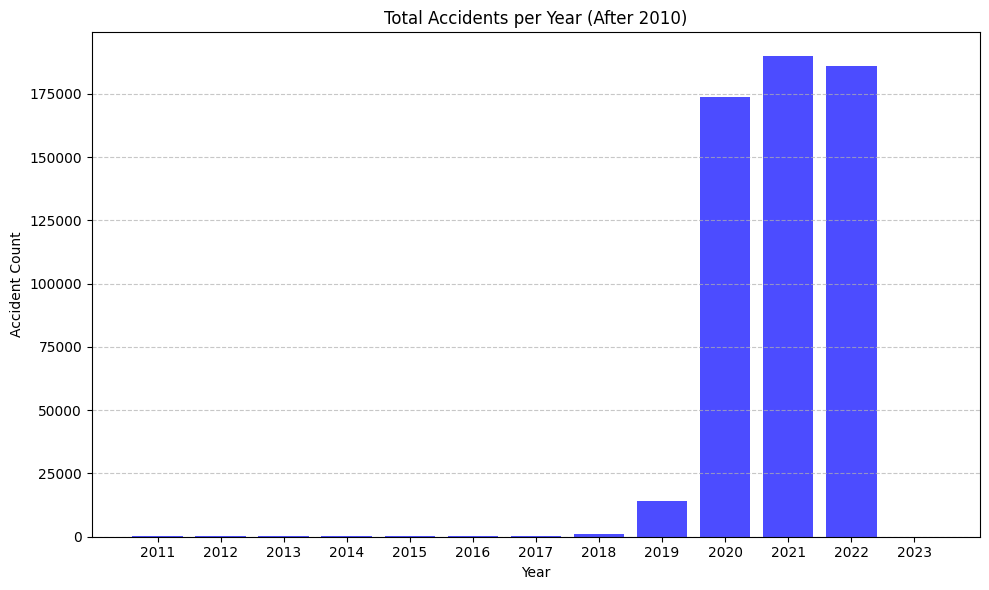

In [91]:
df['Year'] = df['Accident Date'].dt.year
accidents_per_year = df['Year'].value_counts().sort_index()
accidents_per_year_filtered = accidents_per_year[accidents_per_year.index > 2010]
plt.figure(figsize=(10, 6))
plt.bar(accidents_per_year_filtered.index, accidents_per_year_filtered.values, color='b', alpha=0.7)
plt.title('Total Accidents per Year (After 2010)')
plt.xlabel('Year')
plt.ylabel('Accident Count')
plt.xticks(accidents_per_year_filtered.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Explore the Alternative Dispute Resolution variable

In [92]:
df['Alternative Dispute Resolution'].value_counts()

,count
Alternative Dispute Resolution,
N,571412
Y,2609
U,5


This variable is currently categorical, but one of its categories, the 'U' value, has only 5 observations. Since 5 observations are insignificant in this large data frame, we should drop this category and convert it to a boolean type. Another thing is the NAN values wich are about 3%, so we will fill them with the mode.

In [93]:
mode_value = df['Alternative Dispute Resolution'].mode()[0]
df['Alternative Dispute Resolution'] = df['Alternative Dispute Resolution'].fillna(mode_value)
df = df[df['Alternative Dispute Resolution'] != 'U'].copy()
df.loc[:, 'Alternative Dispute Resolution'] = df['Alternative Dispute Resolution'].map({'Y': True, 'N': False})
df['Alternative Dispute Resolution'].value_counts()

<ipython-input-93-c77e72024126>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, 'Alternative Dispute Resolution'] = df['Alternative Dispute Resolution'].map({'Y': True, 'N': False})


,count
Alternative Dispute Resolution,
False,590857
True,2609


In [94]:
df['Alternative Dispute Resolution'].isna().sum()

0

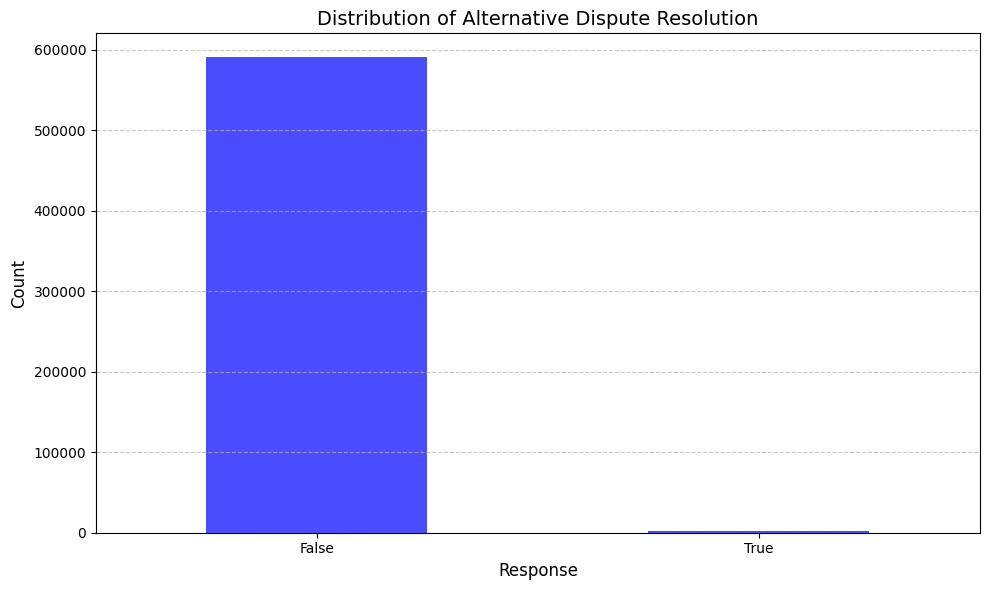

In [95]:

plt.figure(figsize=(10, 6))
df['Alternative Dispute Resolution'].value_counts().plot(kind='bar', color='b', alpha=0.7)
plt.title('Distribution of Alternative Dispute Resolution', fontsize=14)
plt.xlabel('Response', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Explorer the variable Assembly Date and creation of new variable Assembly_time



<ipython-input-107-759726a5ee83>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Assembly Date'].fillna(median_Assembly_date, inplace=True)


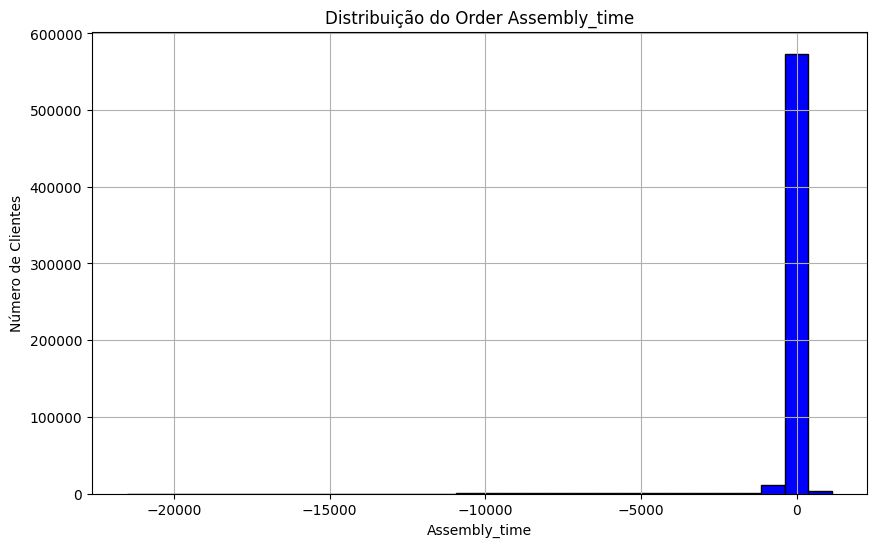

In [107]:
median_Assembly_date = df['Assembly Date'].median()
df['Assembly Date'].fillna(median_Assembly_date, inplace=True)
df['Assembly Date'].isna().sum()
df['Assembly_time'] = df['Accident Date'] - df['Assembly Date']
df['Assembly_time'] = df['Assembly_time'].dt.days
plt.figure(figsize=(10, 6))
plt.hist(df['Assembly_time'].dropna(), bins=30, color='blue', edgecolor='black')
plt.title('Distribuição do Order Assembly_time')
plt.xlabel('Assembly_time')
plt.ylabel('Número de Clientes')
plt.grid(True)
plt.show()

## Explore the variable Attorney/Representative


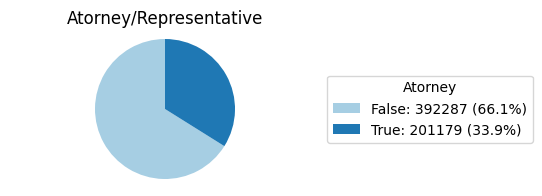

In [111]:
df['Attorney/Representative'].value_counts()
Atorney_counts = df['Attorney/Representative'].value_counts(dropna=True)
colors = plt.cm.Paired(range(len(Atorney_counts)))

# Criar o gráfico de pizza sem percentagens no gráfico
plt.figure(figsize=(4, 2))
wedges, texts = plt.pie(Atorney_counts, startangle=90, colors=colors)

# Adicionar a percentagem na legenda
legend_labels = [f'{region}: {count} ({100 * count / sum(Atorney_counts):.1f}%)' for region, count in zip(Atorney_counts.index, Atorney_counts)]

# Configurar a legenda com nomes das regiões e percentagens
plt.legend(wedges, legend_labels, title="Atorney", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Configurações adicionais
plt.title("Atorney/Representative")
plt.axis('equal')  # Assegurar que o gráfico seja desenhado como um círculo

# Mostrar o gráfico
plt.show()

## Explore the variable Attorney/Representative

### Number of People Injured by Gender

In [ ]:
# Count the frequency of each gender
gender_counts = df['Gender'].value_counts()
print(gender_counts)


M    335218
F    234051
U      4711
X        46
Name: Gender, dtype: int64


### Number of People Injured by Age and Gender

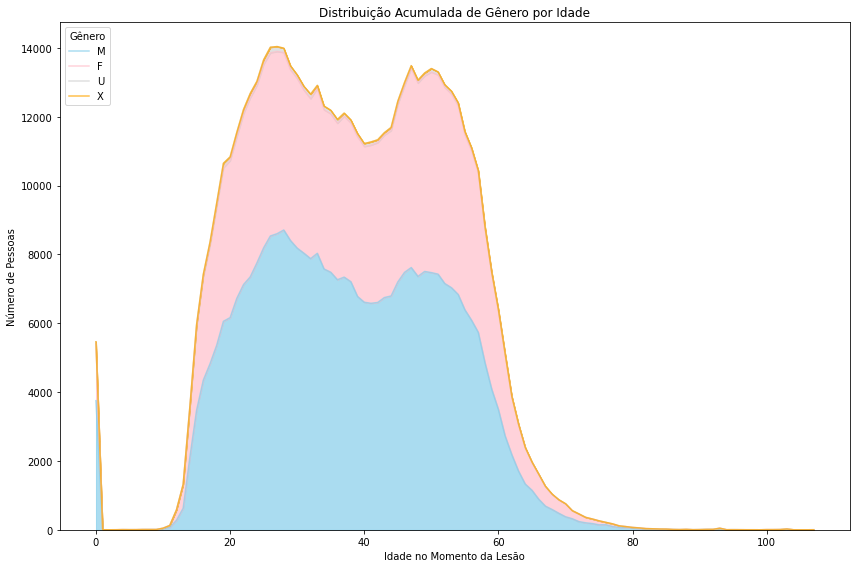

In [ ]:
# Filtering and removing NaN values
df_filtered = df[['Age at Injury', 'Gender', 'Claim Injury Type', 'County of Injury']].dropna()

# Counting the frequency of each age and sorting in ascending order
age_distribution = df_filtered['Age at Injury'].value_counts().sort_index()

# Creating a DataFrame with 'Age at Injury' and 'Total Number of People'
age_distribution_df = pd.DataFrame({'Age at Injury': age_distribution.index,'Total Number of People': age_distribution.values})

# Adding gender distribution
gender_distribution = df_filtered.groupby(['Age at Injury', 'Gender']).size().unstack(fill_value=0)

# Merging the distributions into a single DataFrame
final_df = age_distribution_df.merge(gender_distribution, on='Age at Injury', how='left')

# Setting pandas options to display the entire DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width

# Displaying the final DataFrame
# Gráfico de área empilhada
final_df[['M', 'F', 'U', 'X']].plot(
    kind='area',
    stacked=True,
    figsize=(12, 8),
    color=['skyblue', 'pink', 'lightgray', 'orange'],  # As cores definidas para cada gênero
    alpha=0.7
)

plt.title('Distribuição Acumulada de Gênero por Idade')
plt.xlabel('Idade no Momento da Lesão')
plt.ylabel('Número de Pessoas')

# Corrigindo a legenda para corresponder às cores do gráfico
plt.legend(title='Gênero', labels=['M', 'F', 'U', 'X'], loc='upper left')  # Usar as letras originais
plt.tight_layout()
plt.show()


In [ ]:
# Finding the maximum number of people injured and the corresponding age
max_people = final_df['Total Number of People'].max()
max_age = final_df.loc[final_df['Total Number of People'] == max_people, 'Age at Injury'].values[0]

# Finding the minimum number of people injured and the corresponding age
min_people = final_df['Total Number of People'].min()
min_age = final_df.loc[final_df['Total Number of People'] == min_people, 'Age at Injury'].values[0]

# Displaying the results
print(f'Maximum number of people injured by age: {max_people} at age: {max_age}')
print(f'Minimum number of people injured by age: {min_people} at age: {min_age}')

Maximum number of people injured by age: 14041 at age: 31.0
Minimum number of people injured by age: 1 at age: 5.0


### Number of People Injured by Carrier Type

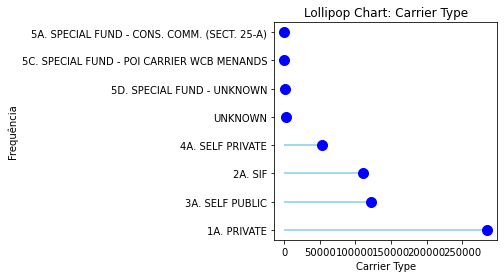

,Carrier Type,Number of People Injured
0,1A. PRIVATE,285368
1,3A. SELF PUBLIC,121920
2,2A. SIF,111144
3,4A. SELF PRIVATE,52788
4,UNKNOWN,1774
5,5D. SPECIAL FUND - UNKNOWN,1023
6,5C. SPECIAL FUND - POI CARRIER WCB MENANDS,5
7,5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A),4


In [ ]:
def plot_lollipop(df, column):
    # Contar a frequência de cada categoria na coluna especificada
    categoria_counts = df[column].value_counts()

    # Criar o gráfico lollipop automaticamente
    plt.figure(figsize=(4, 4))
    plt.hlines(y=categoria_counts.index, xmin=0, xmax=categoria_counts.values, color='skyblue')
    plt.scatter(categoria_counts.values, categoria_counts.index, color='blue', s=100, zorder=2)

    # Adicionar título e rótulos automaticamente
    plt.title(f'Lollipop Chart: {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequência')

    # Mostrar o gráfico
    plt.show()
plot_lollipop(df,'Carrier Type')
# Counting the number of injuries by carrier type while removing NaN values
carrier_distribution = df['Carrier Type'].value_counts()

# Creating a DataFrame for visualization
carrier_distribution_df = pd.DataFrame({'Carrier Type': carrier_distribution.index,'Number of People Injured': carrier_distribution.values})

# Display the carrier distribution DataFrame
carrier_distribution_df

### Number of accidents per year

In [ ]:
df['Accident Year'] = df['Accident Date'].dt.year

accidents_per_year = df.groupby('Accident Year').size()
accidents_per_year

Accident Year
1961.0         1
1963.0         1
1966.0         2
1967.0         3
1969.0         2
1970.0         1
1971.0         3
1972.0         4
1973.0         7
1974.0         5
1975.0         8
1976.0         3
1977.0         8
1978.0         7
1979.0         4
1980.0        12
1981.0        10
1982.0        10
1983.0        10
1984.0        12
1985.0        10
1986.0         7
1987.0        25
1988.0        46
1989.0        35
1990.0        49
1991.0        46
1992.0        59
1993.0        44
1994.0        65
1995.0        77
1996.0       100
1997.0       112
1998.0       111
1999.0       112
2000.0       148
2001.0       491
2002.0       143
2003.0       138
2004.0       174
2005.0       139
2006.0       149
2007.0       162
2008.0       203
2009.0       190
2010.0       236
2011.0       268
2012.0       263
2013.0       295
2014.0       247
2015.0       290
2016.0       318
2017.0       418
2018.0      1211
2019.0     14301
2020.0    173744
2021.0    189803
2022.0    185939


### Number of Injuries by County and Year

In [ ]:
# Ensure 'Accident Year' is created from the 'Accident Date'
df['Accident Year'] = df['Accident Date'].dt.year

# Grouping injuries by County and Year
county_year_group = df.groupby(['County of Injury', 'Accident Year']).size().reset_index(name='Number of Injuries')

# Display the grouped data
county_year_group

,County of Injury,Accident Year,Number of Injuries
0,ALBANY,1981.0,1
1,ALBANY,1986.0,1
2,ALBANY,1989.0,3
3,ALBANY,1990.0,4
4,ALBANY,1991.0,1
5,ALBANY,1995.0,2
6,ALBANY,1996.0,2
7,ALBANY,1997.0,1
8,ALBANY,1998.0,1
9,ALBANY,1999.0,6


### Injury Types by Gender

In [ ]:
# Grouping injuries by Claim Injury Type and Gender
injury_gender_group = df.groupby(['Claim Injury Type', 'Gender']).size().reset_index(name='Number of Injuries')

# Pivot the data for easier readability (optional)
injury_gender_pivot = injury_gender_group.pivot(index='Claim Injury Type', columns='Gender', values='Number of Injuries').fillna(0)

# Display the pivot table
injury_gender_pivot

Gender,F,M,U,X
Claim Injury Type,,,,
1. CANCELLED,4171,8131,172,3
2. NON-COMP,129243,158751,3072,12
3. MED ONLY,28110,40326,452,18
4. TEMPORARY,56128,91551,823,5
5. PPD SCH LOSS,14625,33468,179,8
6. PPD NSL,1691,2507,13,0
7. PTD,23,74,0,0
8. DEATH,60,410,0,0


### Weekly Wage Distribution by Injury Type

In [ ]:
# Grouping by Claim Injury Type and calculating statistics for Average Weekly Wage
wage_distribution = df.groupby('Claim Injury Type')['Average Weekly Wage'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

# Display the wage distribution
wage_distribution

,Claim Injury Type,mean,median,min,max,std
0,1. CANCELLED,7.831938,0.00,0.0,3442.92,98.878750
1,2. NON-COMP,2.866790,0.00,0.0,4289.65,64.738025
2,3. MED ONLY,480.101996,0.00,0.0,1227017.00,4868.507647
3,4. TEMPORARY,1124.643138,940.35,0.0,2659398.00,8515.089178
4,5. PPD SCH LOSS,1551.534581,1367.54,0.0,2828079.00,13433.408422
5,6. PPD NSL,1252.683841,1126.39,0.0,6267.71,685.545033
6,7. PTD,1384.602043,1158.80,250.0,4180.86,771.326877
7,8. DEATH,1049.691151,997.34,0.0,11730.77,967.882363


#Checking for inconsistencies

##Inconsistencies in the dates

In [120]:
def check_date_order(row):
    if (row['Accident Date'] > row['C-2 Date'] or
        row['C-2 Date'] > row['C-3 Date'] or
        row['C-3 Date'] > row['Assembly Date'] or
        row['Assembly Date'] > row['First Hearing Date']):
        return True  # Inconsistency found
    return False  # No inconsistencie

# Apply the function to check the date order and store results in a new column
df['Date_Check'] = df.apply(check_date_order, axis=1)

# Display the DataFrame with the Date_Check column
print(df[['Accident Date','C-2 Date', 'C-3 Date', 'Assembly Date', 'First Hearing Date', 'Date_Check']])

       Accident Date   C-2 Date   C-3 Date Assembly Date First Hearing Date  \
0         2019-12-30 2019-12-31        NaT    2020-01-01                NaT   
1         2019-08-30 2020-01-01 2020-01-14    2020-01-01         2020-02-21   
2         2019-12-06 2020-01-01        NaT    2020-01-01                NaT   
3         2021-06-27        NaT        NaT    2020-01-01                NaT   
4         2019-12-30 2019-12-31        NaT    2020-01-01                NaT   
...              ...        ...        ...           ...                ...   
593466    2021-06-27        NaT        NaT    2022-12-31                NaT   
593467    2022-12-13 2022-12-31        NaT    2022-12-31                NaT   
593468    2021-06-27        NaT        NaT    2022-12-31                NaT   
593469    2021-06-27        NaT        NaT    2022-12-31                NaT   
593470    2021-06-27        NaT        NaT    2022-12-31                NaT   

        Date_Check  
0            False  
1        

# 4. Display Numeric Features

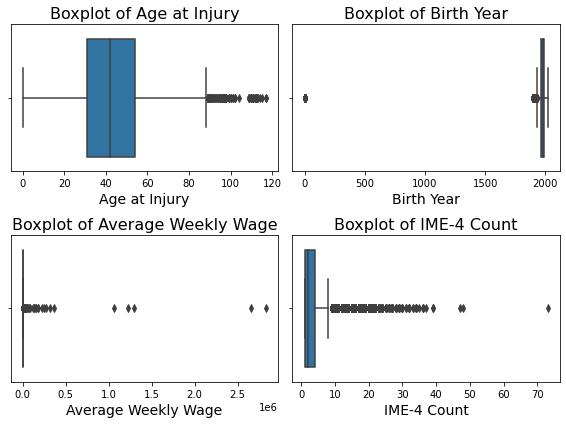

In [ ]:
colunas = ['Age at Injury', 'Birth Year', 'Average Weekly Wage', 'IME-4 Count']
plt.figure(figsize=(8, 6))
for i, coluna in enumerate(colunas):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df, x=coluna)
    plt.title(f'Boxplot of {coluna}', fontsize=16)
    plt.xlabel(coluna, fontsize=14)

plt.tight_layout()
plt.show()

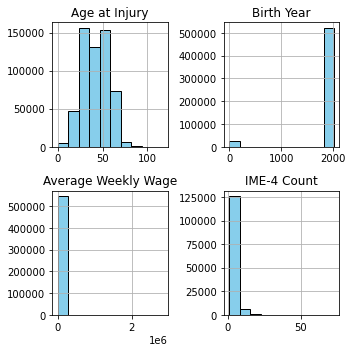

In [ ]:
df[colunas].hist(bins=10, figsize=(5, 5), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

# Correction of the age variable

> Adicionar blockquote



In [ ]:
# Calculate Q1, Q3, and IQR for the column 'Age at Injury'
Q1 = df['Age at Injury'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df['Age at Injury'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define outlier limits
lim_inferior = Q1 - 1.5 * IQR  # Lower limit for outliers
lim_superior = Q3 + 1.5 * IQR  # Upper limit for outliers

# Filter out the outliers
outliers = df[(df['Age at Injury'] < lim_inferior) | (df['Age at Injury'] > lim_superior)]
print(f"Outliers in the column 'Age at Injury':")  # Display message for outliers
print(min(outliers['Age at Injury']))  # Print the minimum value of the outliers

Outliers in the column 'Age at Injury':
89.0


In [ ]:
# Define a valid age range for 'Age at Injury' (16 to 89 years)
df['Age at Injury'] = df['Age at Injury'].apply(lambda x: x if 14 <= x <= 89 else np.nan)

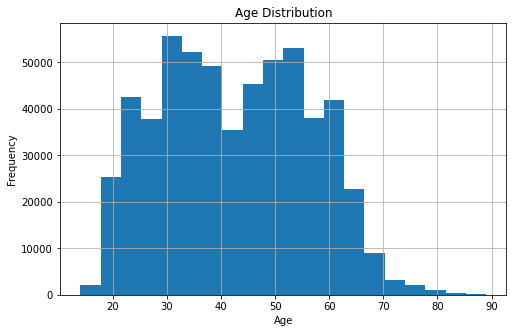

In [ ]:
# Visualize the age distribution
df['Age at Injury'].hist(bins=20, figsize=(8, 5))  # Create a histogram of the 'Age at Injury' column
plt.title('Age Distribution')  # Set the title of the plot
plt.xlabel('Age')  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis
plt.show()  # Display the plot

## Correction of the Birth Year variable


In [ ]:
Q1 = df['Birth Year'].quantile(0.25)
Q3 = df['Birth Year'].quantile(0.75)
IQR = Q3 - Q1

lim_inferior = Q1 - 1.5 * IQR
lim_superior = Q3 + 1.5 * IQR

outliers = df[(df['Birth Year'] < lim_inferior) | (df['Birth Year'] > lim_superior)]
print(f"Outliers in the column 'Birth Year':")
print(max(outliers['Birth Year']))

Outliers in the column 'Birth Year':
1928.0


In [ ]:
df['Birth Year'] = df['Birth Year'].apply(lambda x: x if 1928 <= x else np.nan)

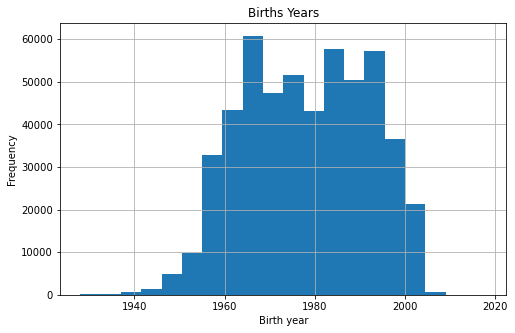

In [ ]:
df['Birth Year'].hist(bins=20, figsize=(8, 5))
plt.title('Births Years')
plt.xlabel('Birth year')
plt.ylabel('Frequency')
plt.show()

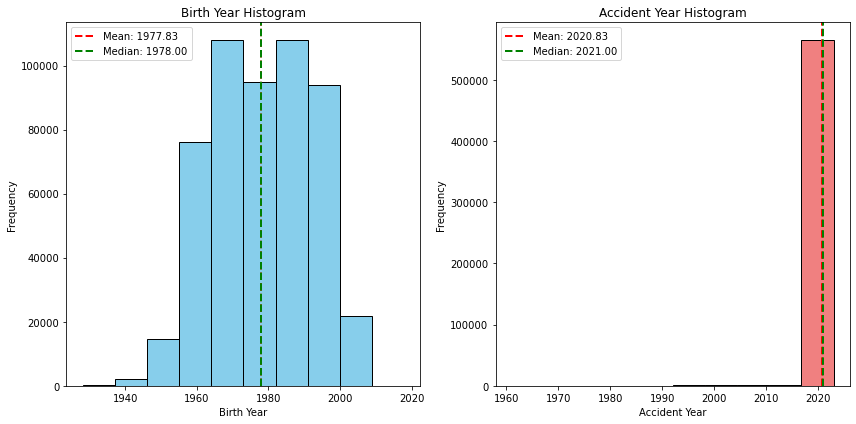

In [ ]:
metric_features = ["Birth Year", "Accident Year"]
df_central = df.copy()
means = df_central[metric_features].mean()
medians = df_central[metric_features].median() # How do we get the median values of our data?
# Plotando os histogramas
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Histograma de Birth Year
axs[0].hist(df_central["Birth Year"].dropna(), bins=10, color='skyblue', edgecolor='black')
axs[0].axvline(means['Birth Year'], color='red', linestyle='dashed', linewidth=2, label=f"Mean: {means['Birth Year']:.2f}")
axs[0].axvline(medians['Birth Year'], color='green', linestyle='dashed', linewidth=2, label=f"Median: {medians['Birth Year']:.2f}")
axs[0].set_title("Birth Year Histogram")
axs[0].set_xlabel("Birth Year")
axs[0].set_ylabel("Frequency")
axs[0].legend()

# Histograma de Accident Year
axs[1].hist(df_central["Accident Year"].dropna(), bins=10, color='lightcoral', edgecolor='black')
axs[1].axvline(means['Accident Year'], color='red', linestyle='dashed', linewidth=2, label=f"Mean: {means['Accident Year']:.2f}")
axs[1].axvline(medians['Accident Year'], color='green', linestyle='dashed', linewidth=2, label=f"Median: {medians['Accident Year']:.2f}")
axs[1].set_title("Accident Year Histogram")
axs[1].set_xlabel("Accident Year")
axs[1].set_ylabel("Frequency")
axs[1].legend()

plt.tight_layout()
plt.show()

## Correction of the Average Weekly Wage variable

In [ ]:
# Average Weekly Wage -> The wage used to calculate workers’ compensation,
# disability, or an Paid Leave wage replacement benefits.

In [ ]:
Q1 = df['Average Weekly Wage'].quantile(0.25)
Q3 = df['Average Weekly Wage'].quantile(0.75)
IQR = Q3 - Q1

lim_inferior = Q1 - 1.5 * IQR
lim_superior = Q3 + 1.5 * IQR

outliers = df[(df['Average Weekly Wage'] < lim_inferior) | (df['Average Weekly Wage'] > lim_superior)]
print(f"Outliers in the column 'Birth Year':")
print(outliers['Average Weekly Wage'])

Outliers in the column 'Birth Year':
27           2115.00
95           2615.80
176          2175.45
199          4371.78
209          2606.99
219          2125.69
250          2306.45
289          2363.00
310          2203.12
325          2488.39
333          2906.86
371          2147.90
375          3311.00
451          3350.69
476          2758.29
504          2599.55
515          2114.97
554          2560.59
595          2278.53
602          2455.09
623          2105.66
650          3055.75
678          2145.15
706          3213.06
743          2999.63
789          2610.61
857          2259.28
886          2323.94
929          2368.50
980          2254.82
1017         2847.22
1032         2256.67
1034         2123.22
1153         2432.38
1177         3224.31
1187         2527.76
1191         2142.04
1193         2940.42
1224         3037.50
1258         3087.46
1288         2570.52
1345         8488.33
1362         4704.67
1367         3049.69
1483         2890.13
1513         2692.

In [ ]:
df = df[(df['Average Weekly Wage'] <= 2126.49)]

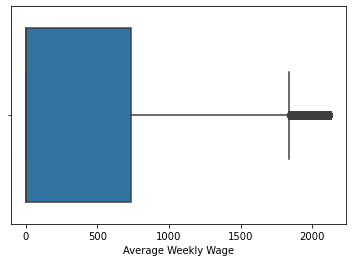

In [ ]:
sns.boxplot(x=df['Average Weekly Wage'])
plt.show()

   ## Lets take a look at the WCIO Cause of Injury Description and Code

In [ ]:
k=df['WCIO Cause of Injury Description'].unique().tolist()
for i in k:
    print(i,df[df['WCIO Cause of Injury Description']==i]['WCIO Cause of Injury Code'].unique().tolist())

FROM LIQUID OR GREASE SPILLS [27.0]
REPETITIVE MOTION [97.0, 94.0]
OBJECT BEING LIFTED OR HANDLED [79.0, 17.0, 66.0]
FALL, SLIP OR TRIP, NOC [31.0]
CUT, PUNCTURE, SCRAPE, NOC [19.0]
OTHER - MISCELLANEOUS, NOC [99.0]
STRUCK OR INJURED, NOC [81.0]
FALLING OR FLYING OBJECT [75.0]
CHEMICALS [1.0]
COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE [45.0]
LIFTING [56.0]
TWISTING [53.0]
ON SAME LEVEL [29.0]
STRAIN OR INJURY BY, NOC [60.0]
MOTOR VEHICLE, NOC [50.0]
FROM DIFFERENT LEVEL (ELEVATION) [25.0]
PUSHING OR PULLING [57.0]
FOREIGN MATTER (BODY) IN EYE(S) [87.0]
FELLOW WORKER, PATIENT OR OTHER PERSON [74.0]
STEAM OR HOT FLUIDS [5.0]
STATIONARY OBJECT [68.0]
HAND TOOL, UTENSIL; NOT POWERED [16.0]
ON ICE OR SNOW [32.0]
ABSORPTION, INGESTION OR INHALATION, NOC [82.0]
PERSON IN ACT OF A CRIME [89.0]
ON STAIRS [33.0]
FROM LADDER OR SCAFFOLDING [26.0]
SLIP, OR TRIP, DID NOT FALL [30.0]
JUMPING OR LEAPING [54.0]
MOTOR VEHICLE [77.0]
RUBBED OR ABRADED, NOC [95.0]
REACHING [58.0]
OBJECT HANDLED [12.0]
H

In [ ]:
k=df['WCIO Cause of Injury Code'].unique().tolist()
for i in k:
    print(i,df[df['WCIO Cause of Injury Code']==i]['WCIO Cause of Injury Description'].unique().tolist())

27.0 ['FROM LIQUID OR GREASE SPILLS']
97.0 ['REPETITIVE MOTION']
79.0 ['OBJECT BEING LIFTED OR HANDLED']
31.0 ['FALL, SLIP OR TRIP, NOC']
19.0 ['CUT, PUNCTURE, SCRAPE, NOC']
99.0 ['OTHER - MISCELLANEOUS, NOC']
81.0 ['STRUCK OR INJURED, NOC']
75.0 ['FALLING OR FLYING OBJECT']
1.0 ['CHEMICALS']
45.0 ['COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE']
56.0 ['LIFTING']
53.0 ['TWISTING']
29.0 ['ON SAME LEVEL']
60.0 ['STRAIN OR INJURY BY, NOC']
50.0 ['MOTOR VEHICLE, NOC']
25.0 ['FROM DIFFERENT LEVEL (ELEVATION)']
57.0 ['PUSHING OR PULLING']
87.0 ['FOREIGN MATTER (BODY) IN EYE(S)']
74.0 ['FELLOW WORKER, PATIENT OR OTHER PERSON']
5.0 ['STEAM OR HOT FLUIDS']
68.0 ['STATIONARY OBJECT']
16.0 ['HAND TOOL, UTENSIL; NOT POWERED']
32.0 ['ON ICE OR SNOW']
82.0 ['ABSORPTION, INGESTION OR INHALATION, NOC']
89.0 ['PERSON IN ACT OF A CRIME']
17.0 ['OBJECT BEING LIFTED OR HANDLED']
33.0 ['ON STAIRS']
26.0 ['FROM LADDER OR SCAFFOLDING']
30.0 ['SLIP, OR TRIP, DID NOT FALL']
54.0 ['JUMPING OR LEAPING']
66.0 ['OBJ

In [ ]:
print(df[df['WCIO Cause of Injury Description']=='OBJECT BEING LIFTED OR HANDLED']['WCIO Cause of Injury Code'].unique())
print(df[df['WCIO Cause of Injury Description']=='REPETITIVE MOTION']['WCIO Cause of Injury Code'].unique())

[79. 17. 66.]
[97. 94.]


In [ ]:
df.loc[df['WCIO Cause of Injury Description'] == 'OBJECT BEING LIFTED OR HANDLED', 'WCIO Cause of Injury Code'] = 79.0

In [ ]:
df.loc[df['WCIO Cause of Injury Description'] == 'REPETITIVE MOTION', 'WCIO Cause of Injury Code'] = 97.0

## Lets take a look at the WCIO Nature of Injury Description and Code

In [ ]:
k=df['WCIO Nature of Injury Description'].unique().tolist()
for i in k:
    print(df[df['WCIO Nature of Injury Description']==i]['WCIO Nature of Injury Code'].unique().tolist())

[10.0]
[49.0]
[7.0]
[40.0]
[71.0]
[59.0]
[37.0]
[4.0]
[52.0]
[28.0]
[25.0]
[46.0]
[90.0]
[16.0]
[80.0]
[34.0]
[43.0]
[3.0]
[1.0]
[]
[36.0]
[13.0]
[53.0]
[42.0]
[78.0]
[65.0]
[31.0]
[77.0]
[47.0]
[19.0]
[72.0]
[60.0]
[68.0]
[69.0]
[73.0]
[2.0]
[41.0]
[54.0]
[66.0]
[58.0]
[91.0]
[55.0]
[74.0]
[32.0]
[75.0]
[22.0]
[61.0]
[67.0]
[83.0]
[76.0]
[30.0]
[62.0]
[64.0]
[38.0]
[79.0]
[70.0]
[63.0]


## Lets take a look at the WCIO part of body Description and Code

In [ ]:
k=df['WCIO Part Of Body Description'].unique().tolist()
for i in k:
    print(i,df[df['WCIO Part Of Body Description']==i]['WCIO Part Of Body Code'].unique().tolist())

BUTTOCKS [62.0]
SHOULDER(S) [38.0]
MULTIPLE HEAD INJURY [10.0]
FINGER(S) [36.0]
LUNGS [60.0]
EYE(S) [14.0]
ANKLE [55.0]
KNEE [53.0]
THUMB [37.0]
LOWER BACK AREA [42.0]
ABDOMEN INCLUDING GROIN [61.0]
LOWER LEG [54.0]
HIP [51.0]
UPPER LEG [52.0]
MOUTH [17.0]
WRIST [34.0]
SPINAL CORD [23.0, 47.0]
HAND [35.0]
SOFT TISSUE [18.0, 25.0]
UPPER ARM [31.0]
FOOT [56.0]
ELBOW [32.0]
MULTIPLE UPPER EXTREMITIES [30.0]
MULTIPLE BODY PARTS (INCLUDING BODY [90.0]
BODY SYSTEMS AND MULTIPLE BODY SYSTEMS [91.0]
MULTIPLE NECK INJURY [20.0]
CHEST [44.0]
WRIST (S) & HAND(S) [39.0]
EAR(S) [13.0]
MULTIPLE LOWER EXTREMITIES [50.0]
LOWER ARM [33.0]
MULTIPLE [-9.0]
DISC [22.0, 43.0]
UPPER BACK AREA [41.0]
SKULL [11.0]
TOES [57.0]
FACIAL BONES [19.0]
nan []
TEETH [16.0]
NO PHYSICAL INJURY [66.0]
MULTIPLE TRUNK [40.0]
WHOLE BODY [99.0]
INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED [65.0]
PELVIS [46.0]
NOSE [15.0]
GREAT TOE [58.0]
INTERNAL ORGANS [48.0]
HEART [49.0]
VERTEBRAE [21.0]
LUMBAR & OR SACRAL VERTEB

In [ ]:
k=df['WCIO Part Of Body Code'].unique().tolist()
for i in k:
    print(i,df[df['WCIO Part Of Body Code']==i]['WCIO Part Of Body Description'].unique().tolist())

62.0 ['BUTTOCKS']
38.0 ['SHOULDER(S)']
10.0 ['MULTIPLE HEAD INJURY']
36.0 ['FINGER(S)']
60.0 ['LUNGS']
14.0 ['EYE(S)']
55.0 ['ANKLE']
53.0 ['KNEE']
37.0 ['THUMB']
42.0 ['LOWER BACK AREA']
61.0 ['ABDOMEN INCLUDING GROIN']
54.0 ['LOWER LEG']
51.0 ['HIP']
52.0 ['UPPER LEG']
17.0 ['MOUTH']
34.0 ['WRIST']
23.0 ['SPINAL CORD']
35.0 ['HAND']
18.0 ['SOFT TISSUE']
31.0 ['UPPER ARM']
25.0 ['SOFT TISSUE']
56.0 ['FOOT']
32.0 ['ELBOW']
30.0 ['MULTIPLE UPPER EXTREMITIES']
90.0 ['MULTIPLE BODY PARTS (INCLUDING BODY']
91.0 ['BODY SYSTEMS AND MULTIPLE BODY SYSTEMS']
20.0 ['MULTIPLE NECK INJURY']
44.0 ['CHEST']
39.0 ['WRIST (S) & HAND(S)']
13.0 ['EAR(S)']
50.0 ['MULTIPLE LOWER EXTREMITIES']
33.0 ['LOWER ARM']
-9.0 ['MULTIPLE']
22.0 ['DISC']
41.0 ['UPPER BACK AREA']
11.0 ['SKULL']
57.0 ['TOES']
19.0 ['FACIAL BONES']
nan []
16.0 ['TEETH']
66.0 ['NO PHYSICAL INJURY']
40.0 ['MULTIPLE TRUNK']
99.0 ['WHOLE BODY']
65.0 ['INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED']
46.0 ['PELVIS']
15.0 ['NOSE']
58.0

Spinal Cord-23,47
Soft Tissue-18,25
Disc-22,43

In [ ]:
df.loc[df['WCIO Part Of Body Description'] == 'Spinal Cord', 'WCIO Part Of Body Code'] = 23.0

In [ ]:
df.loc[df['WCIO Part Of Body Description'] == 'Soft Tissue', 'WCIO Part Of Body Code'] = 23.0

In [ ]:
df.loc[df['WCIO Part Of Body Description'] == 'Disc', 'WCIO Part Of Body Code'] = 23.0